# Self-Attention Visualization

## 1. High-level goals

### Stage 1

Sentence structure: "[ANIMAL\] [SOUND\] [CORRECTNESS\]"

* "cat meows right"
* "dog barks right"
* "cat barks wrong"
* "meows cat wrong"

The model should generalize and deduce "barks cat wrong"

### Stage 2

Sentence structure: "[ANIMAL(S?)\] [SOUND\]"

* "cat meows"
* "cats meow"

### Stage 3

Sentence structure: "[ANIMAL(S?)\] see(s?) [ANIMAL(S?)\], (it|they) [SOUND\]"

* "cat sees birds, it meows"
* "cats see dog, they meow"

### Stage 4

Sentence structure: "[ANIMAL(S?)\] see(s?) [ANIMAL(S?)\], (it|they) [SOUND\] then made [RELATIONSHIP\] with (it|them)"

* "cat sees dogs, it meows then made friends with them"
* "cat sees fly, it meows then made enimies with it"

## 2. Prompts

### 2.1 Generate animal sounds

Generate a Python dictionary variable named `animal_sounds` that maps animal names to the sounds they make, subject to the following requirements:

1. Each animal name is a single English word.
2. Each sound is a single English word.
3. The animal name has distinct singular and plural forms.
4. The sound has distinct singular and plural forms.
5. Use only lowercase letters.
6. Use single quotes for string literals.
7. Indent with two spaces.
8. The more the better, they will be used to generate ML training data.

* ChatGPT 5 Thinking: https://chatgpt.com/share/68ab3a91-1590-8004-a909-6736e2eea239
* Claude Opus 4.1: https://claude.ai/share/881f2e11-f169-4cac-9c30-6e7e2ea274c4
* Gemini 2.5 Pro: https://g.co/gemini/share/9c0b083666e8
* Grok 4 Expert: https://grok.com/share/c2hhcmQtMw%3D%3D_b95bd4e3-666b-4b4f-9b93-1eb5209c452b

### 2.2 Get singular / plural forms

Given the following list of animal names in singular form, generate a Python dictionary named `animal_plural` that maps each name to its plural form. Follow these requirements:

1. Use single-quoted string literals.
2. Indent with two spaces.
3. Map all 251 names.

Animal names:

...

* Gemini 2.5 Pro: https://g.co/gemini/share/633138c2aaa6

Given the following list of animal sounds in plural form, generate a Python dictionary named `sound_singular` that maps each sound to its singular form. Follow these requirements:

1. Use single-quoted string literals.
2. Indent with two spaces.
3. Map all 72 sounds.

Animal sounds:

...

## 3. Data generation

In [1]:
import random

import explain_util as util

In [2]:
SEED: int = 1234
random.seed(SEED)

In [3]:
animals: list[str] = ['dog', 'cat']
sounds: list[str] = sorted([util.get_animal_sound(animal) for animal in animals])
print(f'Unique animals: {len(animals)}')
print(f'Unique sounds: {len(sounds)}')

Unique animals: 2
Unique sounds: 2


In [4]:
text_corpus: list[str] = []
for animal in animals:
    sound = util.get_animal_sound(animal)
    text_corpus.append(f'{animal} {sound} right')
    # text_corpus.append(f'{sound} {animal} wrong')
    wrong_sound = sound
    while wrong_sound == sound:
        wrong_sound = random.choice(sounds)
    text_corpus.append(f'{animal} {wrong_sound} wrong')

text_corpus = [
    "cat meows right",
    "dog barks right",
    "cat barks wrong",
    "dog meows wrong",
]
# random.shuffle(text_corpus)
example = text_corpus[0]
print(f'Number of sentences: {len(text_corpus)}')
print(f'Example: "{example}"')

Number of sentences: 4
Example: "cat meows right"


## 4. Tokenizer

In [5]:
from bidict import bidict

class TokenizerV1:
    def __init__(self, vocab: list[int]):
        self._word_to_token_id: bidict[str, int] = bidict(
            {word: i for i, word in enumerate(['wrong', 'right'] + vocab)}
        )

    @property
    def vocab_size(self) -> int:
        return len(self._word_to_token_id)

    def encode(self, content: str) -> list[int]:
        return [self._word_to_token_id[word] for word in content.split()]

    def decode(self, token_ids: list[int]) -> str:
        return ' '.join([self._word_to_token_id.inverse[token] for token in token_ids])

In [6]:
vocab: list[str] = animals + sounds
random.shuffle(vocab)
tokenizer = TokenizerV1(vocab)

In [7]:
encoded: list[int] = tokenizer.encode(example)
decoded: str = tokenizer.decode(encoded)
print(f'Vocabulary size: {tokenizer.vocab_size}')
print(f'Example: "{example}"')
print(f'Encoded: {encoded}')
print(f'Decoded: "{decoded}" (matches: {example == decoded})')

Vocabulary size: 6
Example: "cat meows right"
Encoded: [2, 4, 1]
Decoded: "cat meows right" (matches: True)


In [8]:
encoded: list[list[int]] = [tokenizer.encode(sentence) for sentence in text_corpus]
data: list[(list[int], list[int])] = [(sentence[:2], [sentence[2]]) for sentence in encoded]
print(f'Example data: {data[0]} ---> ([{tokenizer.decode(data[0][0])}] [{tokenizer.decode(data[0][1])}])')

Example data: ([2, 4], [1]) ---> ([cat meows] [right])


## 5. Embedding alone

In [9]:
import torch

import numpy as np
import torch.nn as nn

from torch.nn import functional as F

In [10]:
torch.manual_seed(SEED)

In [11]:
x = torch.tensor([ele[0] for ele in data])
y = torch.tensor([ele[1] for ele in data])

In [12]:
class WordEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 2):
        super().__init__()
        self._token_embed = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._token_embed(x)

In [13]:
embedding = WordEmbeddings(tokenizer.vocab_size)
print(f'Example: {embedding(torch.tensor(data[0][0]))}')
print(f'Result shape: {embedding(x).shape}')

Example: tensor([[-0.6123,  0.5036],
        [-0.2669,  2.1785]], grad_fn=<EmbeddingBackward0>)
Result shape: torch.Size([4, 2, 2])


In [14]:
class EmbeddingAndFC(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 2):
        super().__init__()
        self._embed = WordEmbeddings(vocab_size, embed_dim=embed_dim)

    def forward(
        self,
        x: torch.Tensor,
        y: torch.Tensor | None = None
    ) -> (torch.Tensor, torch.Tensor | None):
        embedding = self._embed(x)
        v1 = embedding[:, 0, :]
        v2 = embedding[:, 1, :]
        result = torch.sum(v1 * v2, dim=1, keepdim=True)
        loss = None
        if y is not None:
            loss = F.binary_cross_entropy_with_logits(result.squeeze(), y.squeeze())
        return result, loss

    def predict(self, text: str) -> float:
        tokenized = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
        with torch.no_grad():
            result, _ = self.forward(tokenized)
            probability = torch.sigmoid(result).item()
        return probability

    def get_word_embedding(self, word: str, tokenizer: TokenizerV1) -> np.ndarray:
        return self._embed(torch.tensor(tokenizer.encode(word))).cpu().detach().numpy()[0]

In [15]:
model = EmbeddingAndFC(tokenizer.vocab_size)
num_params = sum(p.numel() for p in model.parameters())
print(f'Model parameters: {num_params}')
print(f'Forward (no y):\n{model(x)}')
print(f'Forward (with y):\n{model(x, y.to(torch.float32))}')

Model parameters: 12
Forward (no y):
(tensor([[ 0.5866],
        [-0.9107],
        [-0.8809],
        [ 0.6928]], grad_fn=<SumBackward1>), None)
Forward (with y):
(tensor([[ 0.5866],
        [-0.9107],
        [-0.8809],
        [ 0.6928]], grad_fn=<SumBackward1>), tensor(0.7840, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>))


## 6. Visualize embedding before training

In [16]:
import matplotlib.pyplot as plt

In [17]:
def get_vocab_embeddings(final_nn: EmbeddingAndFC, vocab: list[str]) -> dict[str, np.ndarray]:
    result = dict()
    for word in vocab:
        result[word] = final_nn.get_word_embedding(word, tokenizer)
    return result

In [18]:
def plot_2d(title: str, points: dict[str, np.ndarray]):
    """
    Plots 2D vectors as arrows starting from the origin.

    Args:
        title: The title of the plot.
        points: A dictionary where keys are labels and values are 2D NumPy arrays (vectors).
    """
    labels = list(points.keys())
    coords = np.array(list(points.values()))

    # 1. Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    animals_set = set(animals)

    # 2. Loop through each point to plot an arrow and its label
    for i, label in enumerate(labels):
        x, y = coords[i]

        color = 'orange' if label in animals_set else 'blue'
        # Plot the arrow from origin (0,0) to the point (x,y)
        ax.arrow(0, 0, x, y, 
                 head_width=0.1, 
                 head_length=0.2, 
                 fc=color, 
                 ec=color,
                 length_includes_head=True)
        
        # Add the label near the arrowhead
        ax.annotate(label, (x, y),
                    textcoords="offset points", # Position the text
                    xytext=(0, 10),             # Distance from text to points (x,y)
                    ha='center')                # Horizontal alignment

    # 3. Determine the plot limits to ensure all arrows are visible
    max_val = np.max(np.abs(coords)) * 1.2 # Find max coordinate value and add 20% padding
    ax.set_xlim([-max_val, max_val])
    ax.set_ylim([-max_val, max_val])

    # 4. Add axes lines for reference
    ax.axhline(0, color='grey', lw=1, linestyle='--')
    ax.axvline(0, color='grey', lw=1, linestyle='--')

    # 5. Customize and show the plot
    ax.set_title(title)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.grid(True)
    ax.set_aspect('equal', adjustable='box') # Ensure arrows aren't distorted
    plt.tight_layout()
    plt.show()

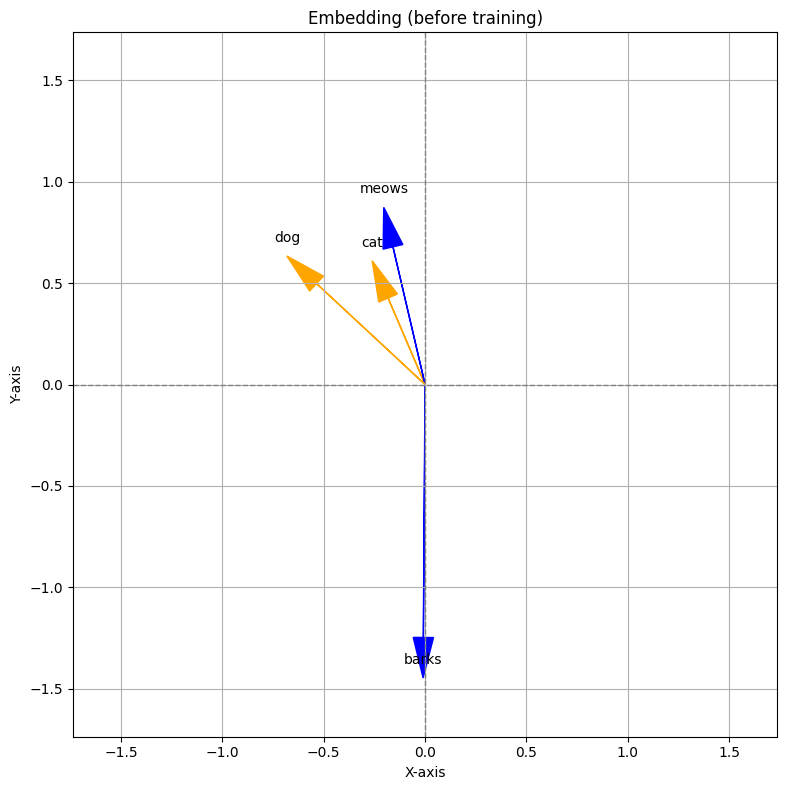

In [19]:
plot_2d('Embedding (before training)', get_vocab_embeddings(model, vocab))

## 7. Training

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
for epoch in range(10_000):
    output, loss = model(x, y.to(torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

print(f'Final Loss: {loss.item():.4f}')
print(f'Targets:\n{y}')

Epoch 0, Loss: 0.7840
Epoch 500, Loss: 0.3798
Epoch 1000, Loss: 0.0928
Epoch 1500, Loss: 0.0315
Epoch 2000, Loss: 0.0146
Epoch 2500, Loss: 0.0080
Epoch 3000, Loss: 0.0049
Epoch 3500, Loss: 0.0032
Epoch 4000, Loss: 0.0022
Epoch 4500, Loss: 0.0015
Epoch 5000, Loss: 0.0011
Epoch 5500, Loss: 0.0008
Epoch 6000, Loss: 0.0006
Epoch 6500, Loss: 0.0004
Epoch 7000, Loss: 0.0003
Epoch 7500, Loss: 0.0002
Epoch 8000, Loss: 0.0002
Epoch 8500, Loss: 0.0001
Epoch 9000, Loss: 0.0001
Epoch 9500, Loss: 0.0001
Final Loss: 0.0001
Targets:
tensor([[1],
        [1],
        [0],
        [0]])


In [21]:
print(f'Unseen example: {model.predict('dog meows')}')

Unseen example: 9.082032192964107e-05


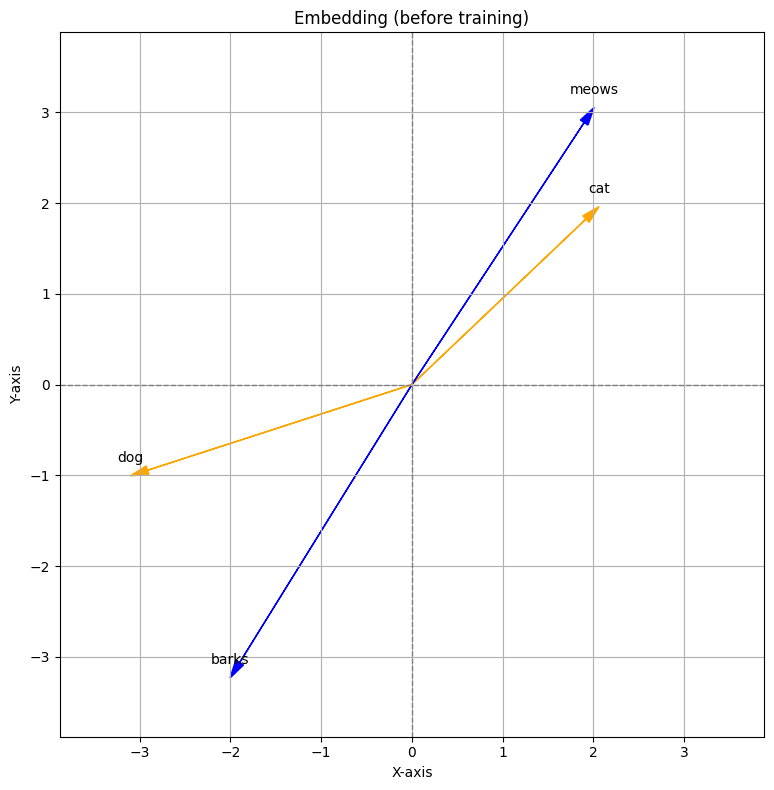

In [22]:
plot_2d('Embedding (after training)', get_vocab_embeddings(model, vocab))